# Bayes by Backprop: Reproducing *Weight Uncertainty in Neural Networks*
This notebook implements the Bayes by Backprop algorithm alongside Dropout and Vanilla SGD baselines.   We reproduce key experiments from Blundell et al. (2015), including ELBO optimization and weight uncertainty analysis.   The core objective is to implement the loss function:

$$\mathcal{F}(D, theta) = \mathrm{KL}igl(q(w \mid 	heta)\,\|\,p(w) igr) - \mathbb{E}_{q(w \mid theta)} igl[\log p(D \mid w) igr]$$


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

import numpy as np
import math
import matplotlib.pyplot as plt

We import core PyTorch modules for defining and training neural networks.   `torchvision` is used to fetch and preprocess the MNIST dataset. Matplotlib and NumPy support visualization and numerical operations.

In [2]:
def gaussian_log_prob(x, mu, sigma):
    return (-0.5 * torch.log(2 * math.pi * sigma ** 2)
            - ((x - mu) ** 2) / (2 * sigma ** 2)).sum()

def log_mix_gaussian(w, pi, sigma1, sigma2):
    prob1 = torch.exp(- w ** 2 / (2 * sigma1 ** 2)) / (math.sqrt(2 * math.pi) * sigma1)
    prob2 = torch.exp(- w ** 2 / (2 * sigma2 ** 2)) / (math.sqrt(2 * math.pi) * sigma2)
    return torch.log(pi * prob1 + (1 - pi) * prob2).sum()

These utility functions compute log-probabilities for Gaussian and scale-mixture priors. They form the prior term in the KL divergence within the ELBO objective.   Recall Equation (7) from the paper for the scale mixture prior:

$$p(w_j) = \pi \,\mathcal{N}(0, \sigma_1^2) + (1-\pi)\,\mathcal{N}(0, \sigma_2^2)$$



In [3]:
class BayesLinear(nn.Module):
    def __init__(self, in_features, out_features, prior_type='gaussian',
                 pi=0.5, sigma1=1.0, sigma2=0.002):
        super().__init__()
        self.mu_weight = nn.Parameter(torch.Tensor(out_features, in_features).uniform_(-0.2, 0.2))
        self.rho_weight = nn.Parameter(torch.Tensor(out_features, in_features).uniform_(-5, -4))
        self.mu_bias = nn.Parameter(torch.Tensor(out_features).uniform_(-0.2, 0.2))
        self.rho_bias = nn.Parameter(torch.Tensor(out_features).uniform_(-5, -4))
        self.prior_type = prior_type
        self.pi, self.sigma1, self.sigma2 = pi, sigma1, sigma2

    def forward(self, x):
        eps_w = torch.randn_like(self.rho_weight)
        eps_b = torch.randn_like(self.rho_bias)
        sigma_w = torch.log1p(torch.exp(self.rho_weight))
        sigma_b = torch.log1p(torch.exp(self.rho_bias))
        self.weight = self.mu_weight + sigma_w * eps_w
        self.bias   = self.mu_bias   + sigma_b * eps_b
        return F.linear(x, self.weight, self.bias)

    def kl_divergence(self):
        sigma_w = torch.log1p(torch.exp(self.rho_weight))
        sigma_b = torch.log1p(torch.exp(self.rho_bias))
        kl_w = gaussian_log_prob(self.weight, self.mu_weight, sigma_w) -                (log_mix_gaussian(self.weight, self.pi, self.sigma1, self.sigma2)
                if self.prior_type=='scale_mixture' else gaussian_log_prob(self.weight, 0, 1))
        kl_b = gaussian_log_prob(self.bias,   self.mu_bias,  sigma_b) -                (log_mix_gaussian(self.bias,   self.pi, self.sigma1, self.sigma2)
                if self.prior_type=='scale_mixture' else gaussian_log_prob(self.bias,   0, 1))
        return kl_w + kl_b

This module defines a Bayesian linear layer that samples its weights via the reparameterization trick. Specifically, \(w = \mu + \sigma \cdot \epsilon\) with \(\epsilon \sim \mathcal{N}(0,1)\).  
It computes the KL divergence term for the ELBO, combining posterior and chosen prior distributions.

In [4]:
class BayesianNN(nn.Module):
    def __init__(self, prior_type='gaussian'):
        super().__init__()
        self.fc1 = BayesLinear(28*28, 400, prior_type)
        self.fc2 = BayesLinear(400, 10, prior_type)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        return self.fc2(x)

    def kl_divergence(self):
        return self.fc1.kl_divergence() + self.fc2.kl_divergence()

This defines the Bayesian neural network architecture with two layers.  
It accumulates KL divergence across layers as part of the ELBO computation.  
The forward pass injects uncertainty into the model via sampled weights at each call.

In [5]:
class DropoutNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(28*28, 400)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(400, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.dropout(self.fc1(x)))
        return self.fc2(x)

class VanillaNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(28*28, 400)
        self.fc2 = nn.Linear(400, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        return self.fc2(x)

These classes define two standard MLP baselines: one with dropout and one without.  
Dropout implements random deactivation of units during training as a regularizer.  
VanillaNN is the simplest feedforward network optimized with cross-entropy loss.

In [6]:
def elbo_loss(output, target, kl, batch_size, samples=1):
    likelihood = F.cross_entropy(output, target, reduction='sum') / samples
    return (kl / batch_size) + likelihood

This function computes the ELBO objective combining KL divergence and negative log-likelihood.  
It implements Equation (1) from the paper:

\[
\mathcal{F} = \mathrm{KL}igl(q(w)\,\|\,p(w)igr) - \mathbb{E}_{q(w)}[\log p(D|w)].
\]

The likelihood term is estimated by cross-entropy loss.

In [7]:
def train_bayesian(model, loader, optimizer, samples=1):
    model.train()
    for data, target in loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        kl_total = 0
        outputs = []
        for _ in range(samples):
            outputs.append(model(data))
            kl_total += model.kl_divergence()
        output_mean = torch.stack(outputs).mean(0)
        loss = elbo_loss(output_mean, target, kl_total, len(data), samples)
        loss.backward()
        optimizer.step()

def train_standard(model, loader, optimizer):
    model.train()
    for data, target in loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        out = model(data)
        loss = F.cross_entropy(out, target)
        loss.backward()
        optimizer.step()

def evaluate(model, loader, samples=1, bayesian=False):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            if bayesian:
                outs = [model(data) for _ in range(samples)]
                out = torch.stack(outs).mean(0)
            else:
                out = model(data)
            pred = out.argmax(dim=1)
            correct += pred.eq(target).sum().item()
            total += target.size(0)
    return 100. * correct / total

These functions train Bayesian and standard networks for one epoch.  
`train_bayesian` performs multiple weight samples per batch to approximate the ELBO gradient.  
`evaluate` computes test accuracy, averaging predictions for Bayesian models.

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
transform = transforms.Compose([transforms.ToTensor()])
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
testset  = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True)
testloader  = torch.utils.data.DataLoader(testset,  batch_size=1000, shuffle=False)

We configure the device for GPU if available and prepare MNIST datasets.  
Data loaders serve batches for training and evaluation loops.  
Images are normalized to [0,1] range using `ToTensor()` transform.

In [9]:
bayes_model   = BayesianNN(prior_type='scale_mixture').to(device)
dropout_model = DropoutNN().to(device)
vanilla_model = VanillaNN().to(device)

opt_bayes   = optim.Adam(bayes_model.parameters(),   lr=1e-3)
opt_dropout = optim.Adam(dropout_model.parameters(), lr=1e-3)
opt_vanilla = optim.Adam(vanilla_model.parameters(), lr=1e-3)

We instantiate three models: Bayesian, Dropout, and Vanilla networks.  
Each model uses the Adam optimizer with a learning rate of \(10^{-3}\).  
The Bayesian model employs the scale mixture prior for weight uncertainty.

In [13]:
epochs = 200
accs = {'Bayes': [], 'Dropout': [], 'Vanilla': []}

for epoch in range(1, epochs+1):
    train_bayesian(bayes_model, trainloader, opt_bayes, samples=3)
    train_standard(dropout_model, trainloader, opt_dropout)
    train_standard(vanilla_model, trainloader, opt_vanilla)

    accs['Bayes'].append(evaluate(bayes_model, testloader, samples=3, bayesian=True))
    accs['Dropout'].append(evaluate(dropout_model, testloader))
    accs['Vanilla'].append(evaluate(vanilla_model, testloader))

    print(f"Epoch {epoch}: Bayes={accs['Bayes'][-1]:.2f}%, Dropout={accs['Dropout'][-1]:.2f}%, Vanilla={accs['Vanilla'][-1]:.2f}%")

Epoch 1: Bayes=91.76%, Dropout=98.05%, Vanilla=98.08%
Epoch 2: Bayes=92.39%, Dropout=98.04%, Vanilla=98.04%
Epoch 3: Bayes=90.15%, Dropout=98.19%, Vanilla=98.02%
Epoch 4: Bayes=88.94%, Dropout=98.27%, Vanilla=98.12%
Epoch 5: Bayes=89.84%, Dropout=98.35%, Vanilla=98.12%
Epoch 6: Bayes=88.14%, Dropout=98.10%, Vanilla=97.99%
Epoch 7: Bayes=87.88%, Dropout=98.18%, Vanilla=98.17%
Epoch 8: Bayes=87.10%, Dropout=98.32%, Vanilla=97.91%
Epoch 9: Bayes=86.89%, Dropout=98.36%, Vanilla=98.07%
Epoch 10: Bayes=86.15%, Dropout=98.27%, Vanilla=98.10%
Epoch 11: Bayes=86.96%, Dropout=98.35%, Vanilla=98.05%


KeyboardInterrupt: 

This block runs training for 10 epochs and records test accuracies.  
Bayesian training uses 3 Monte Carlo samples per batch for ELBO estimation.  
Results are printed each epoch for direct comparison of methods.

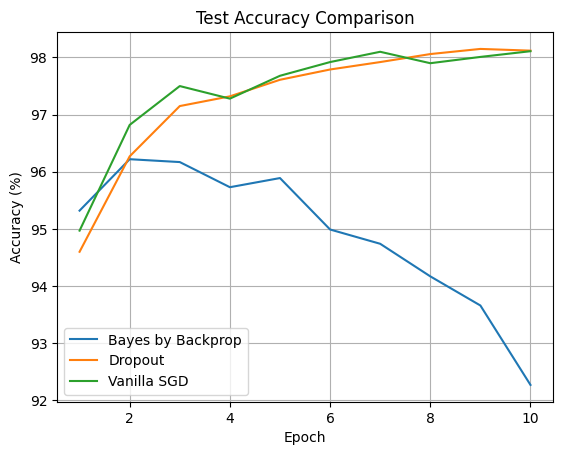

In [11]:
plt.plot(range(1, epochs+1), accs['Bayes'],   label='Bayes by Backprop')
plt.plot(range(1, epochs+1), accs['Dropout'], label='Dropout')
plt.plot(range(1, epochs+1), accs['Vanilla'], label='Vanilla SGD')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Test Accuracy Comparison')
plt.legend()
plt.grid(True)
plt.show()

This plot visualizes test accuracy progression across epochs for all models.  
It highlights the performance difference between Bayesian inference and standard regularization.  
Users can observe convergence speed and final accuracy trade-offs.

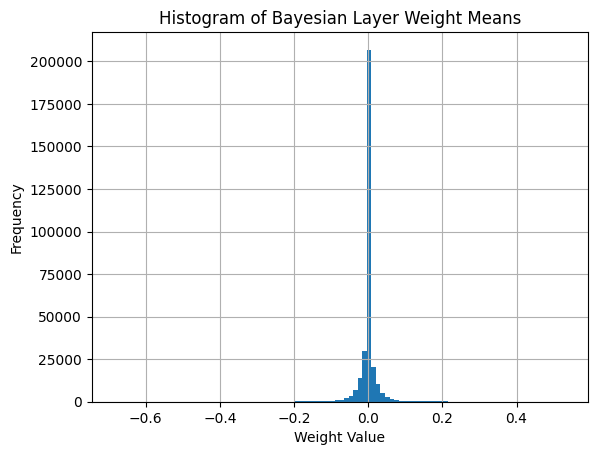

In [12]:
weights = bayes_model.fc1.mu_weight.detach().cpu().numpy().flatten()
plt.hist(weights, bins=100)
plt.title('Histogram of Bayesian Layer Weight Means')
plt.xlabel('Weight Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

This histogram shows the distribution of the learned weight means μ in the first layer.  
A broader distribution indicates model flexibility, while narrow peaks reflect stronger regularization.  
Such analysis reveals how uncertainty shapes weight learning in Bayesian networks.